### Project 1 - Centrality Measures
Daniel Dittenhafer

The Routes data was downloaded from OpenFlights.org on Sept 11, 2016. The following analysis focuses on American Airlines (AA) and examines the hub status of airports as compared to the city to city routes (edges) provided by the OpenFlights data.

* [OpenFlights.org - Routes](http://openflights.org/data.html#route)
* [Video Link](https://1drv.ms/v/s!Aq99FFkqmjPOgYBPOcA1X7ypuHLilA)

### Load the Data

In [52]:
import csv
import urllib2

rawEdges = {}
maxEdges = 100000
cntEdge = 0
airline = "AA" # American Airlines - http://www.iata.org/publications/Pages/code-search.aspx

# Request the OpenFlights route data
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"
response = urllib2.urlopen(url)
#fp = open('openflights-routes.dat', 'r')
rdr = csv.DictReader(filter(lambda row: row[0]!='#', response), 
                     fieldnames=["airline", "airlineId", "origin", "originId", "destintation", "destinationId", "codeshare", "stops", "equipment"])
for row in rdr:
    # Only for the airline we care about
    if row["airline"] == airline:
        f = row["origin"]
        t = row["destintation"]
        if f  not in rawEdges:
            rawEdges[f] = []

        rawEdges[f].append([f, t])

        # Limit ourselves since this dataset has 
        # many more vertices than we need for now.
        cntEdge = cntEdge + 1
        if(cntEdge >= maxEdges):
            break

# Clean up
#fp.close()    

In [53]:
len(rawEdges)

429

In [54]:
rawEdges["EWR"] # EWR = Newark

[['EWR', 'CLT'],
 ['EWR', 'DFW'],
 ['EWR', 'HKG'],
 ['EWR', 'LHR'],
 ['EWR', 'MIA'],
 ['EWR', 'ORD'],
 ['EWR', 'ORY'],
 ['EWR', 'PHL'],
 ['EWR', 'PHX'],
 ['EWR', 'SEA']]

#### Airport Meta Data

This data is used to enrich the original route data. It was downloaded from the American Airlines Routes map page: [http://aa.fltmaps.com/en/data](http://aa.fltmaps.com/en/data)

In [55]:
# Load the JSON file with Hub info
import json
url = "http://aa.fltmaps.com/en/data"
response = urllib2.urlopen(url)
#with open('AmericanAirlines-Routes.json') as data_file:    
data = json.load(response)

In [56]:
# Prove data was loaded
len(data["Cities"])

545

The following functions help with enriching the edge data with the attribute values.

In [57]:
def IsHub(data, airportCode):
    for row in data["Cities"]:
        #print row
        if(row[u"Code"] == airportCode):
            return row[u"IsHub"]
    
    return False

def CountryCode(data, airportCode):
    for row in data["Cities"]:
        #print row
        if(row[u"Code"] == airportCode):
            return row[u"CountryCode"]
    
    return "Unknown Country"

def GetAaHubs(data):
    hubs = []
    for row in data["Cities"]:
        #print row
        if row[u"IsHub"]:
            hubs.append(row[u"Code"]) 
    return hubs

In [58]:
IsHub(data, "LON")

False

In [59]:
CountryCode(data, "LON")

u'GB'

#### Snowball Sampling Function

In [60]:
def snowball_sampling(nl, root, gle, depth, max_depth, taboo_list = [], graphLabEdges = True):
    '''This function recursively walks into the network and builds the edge list. It is based on the snowball_sampling
    function described in Chapter 3 of Social Network Analysis for Startups by Maksim Tsvetovat and Alexander Kouznetsov.
    
    graphLabEdges: This parameter determines whether the eduge is a GraphLab Edge object or a simple python tuple.'''
    depth = depth + 1
    if(depth <= max_depth and root in nl):
        # have we worked on this root already?
        if(root in taboo_list):
            # Yes
            return gle
        else:
            # Not yet
            taboo_list.append(root)
            
        for f, t in nl[root]:
            if (graphLabEdges):
                gle.append(gl.Edge(f,t))
            else:
                gle.append([f,t])
            
            # Recursive function
            gle = snowball_sampling(nl, t, gle, depth, max_depth, taboo_list, graphLabEdges)
            
    return gle

#### GraphLab 

In [61]:
import graphlab as gl
g = gl.SGraph()
glEdges = []
glEdges = snowball_sampling(rawEdges, "EWR", glEdges, 0, 2, [])

g = g.add_edges(glEdges)

In [62]:
#g.get_vertices(ids=["EWR"])
#g.vertices.add_column("is_hub")

#### GraphLab Visualization

In [63]:
gl.canvas.set_target('ipynb')
g.show(vlabel='id', arrows=True, highlight={"0":[0.69, 0., 0.498]})
# Does not show on GitHub rendition

### NetworkX
The following section uses NetworkX. We snowball sample the edges starting with Newark Airport (EWR), going to a max depth of 4.

In [64]:
import networkx as nx
nx.__version__

'1.11'

In [65]:
gx = nx.DiGraph()
tEdges = []
tEdges = snowball_sampling(rawEdges, "EWR", tEdges, 0, 50, [], False)
for f,t in tEdges:
    gx.add_edge(f,t)

# How many edges did we get?
len(tEdges)

2347

The following code loop adds the attributes using the helper functions defined above and then shows some examples:

In [66]:
hubslist = []
for n in gx.nodes_iter():
    gx.node[n]["countryCode"] = CountryCode(data, n)
    gx.node[n]["is_hub"] = IsHub(data, n)
    if gx.node[n]["is_hub"]:
        hubslist.append(n)

In [67]:
gx.node["DCA"]["is_hub"]

False

In [68]:
IsHub(data, "WAS")

True

In [69]:
gx.node["DFW"]["countryCode"]

u'US'

#### Top 20 Degrees
Here we extract out the top 10 and 20 degree nodes. Notice the drop off in degree value between JFK at 108 and the following entry LGA at 54.

In [70]:
from operator import itemgetter
sortedDegrees = sorted(gx.degree().items(), key=itemgetter(1), reverse=True)
top10 = sortedDegrees[:10]
top20 = sortedDegrees[:20]
top20

[('DFW', 364),
 ('CLT', 267),
 ('ORD', 248),
 ('MIA', 240),
 ('PHL', 235),
 ('LHR', 188),
 ('DCA', 148),
 ('PHX', 148),
 ('LAX', 138),
 ('JFK', 121),
 ('SEA', 54),
 ('LGA', 54),
 ('BOS', 46),
 ('NRT', 44),
 ('SAN', 36),
 ('PDX', 35),
 ('LAS', 30),
 ('SFO', 30),
 ('MCO', 28),
 ('PIT', 28)]

#### Centrality Comparison
Below, we define 2 helper functions which partition the centrality by attribute value and then generate and show some basic statistics

In [71]:
import numpy
import scipy.stats as stats
import math

# Helper function to help us distill some statistics about the attribute and centrality level accros nodes.
def CentralityByAttribute(attrName, centDict):
    attrCent = {}
    for n in gx.nodes_iter():
        atVal = gx.node[n][attrName]
        if atVal not in attrCent:
            attrCent[atVal] = []
            #attrCent[atVal]["sum"] = 0
            #attrCent[atVal]["n"] = 0

        attrCent[atVal].append(centDict[n])
        
    return attrCent

# Helper function to aid with displaying the centrality by category statistics.
def DisplayCentralityStats(attrName, centralitiesByAttr):
    results = {}
    # Show me
    for a in centralitiesByAttr:
        arr = numpy.array(centralitiesByAttr[a])
        m = numpy.mean(arr)
        s = numpy.std(arr)
        n = len(arr)
        
        results[a] = {}
        results[a]["mean"] = m
        results[a]["stdev"] = s
        results[a]["n"] = n
        
        print(attrName + ": " + str(a))
        print("-----")
        print("mean: " + str(m))
        print("stdev: " + str(s))
        print
        
    return results

##### Degree Centrality Analysis

In [72]:
attrToAnalyze = "is_hub"

# Get the degree centrality from NetworkX
dc = nx.degree_centrality(gx)
hubDegCent = CentralityByAttribute(attrToAnalyze, dc)

# Show me
centStats = DisplayCentralityStats(attrToAnalyze, hubDegCent)

# T-test on difference of means
diffOfMeans = centStats[False]["mean"] - centStats[True]["mean"]
varTrue = numpy.power(centStats[True]["stdev"], 2)
varFalse = numpy.power(centStats[False]["stdev"], 2)

SE = math.sqrt((varTrue / centStats[True]["n"]) + (varFalse / centStats[False]["n"]))
#print SE

T = (diffOfMeans - 0) / SE
print("t-statistic: " + str(T))

# Use the less of the two sample n's as df
df = centStats[True]["n"]
if centStats[False]["n"] < centStats[True]["n"]:
    df = centStats[False]["n"]
print("DF: " + str(df))

pval = stats.t.sf(numpy.abs(T), df-1)*2
print("p-value: " + str(pval))

is_hub: False
-----
mean: 0.0183246944959
stdev: 0.0434503660406

is_hub: True
-----
mean: 0.543325526932
stdev: 0.177878064185

t-statistic: -7.22651787944
DF: 6
p-value: 0.000791486036279


We performed a difference of means t-test on the results with the null hypothesis being there was no statisically significant difference. The t-statistic was approx -7.2 with a p-value < 0.05, therefore we conclude null hypothesis is not supported and the difference is significant. The airports which are hubs have a different degree centrality than those airports which aren't hubs.

##### Eigenvector Centrality Analysis
Next we look at eigenvector centrality. The helper functions are again useful for partitioning the results and we see that the means are different that the degree centrality.

In [73]:
# Get Eigenvector centrality
ec = nx.eigenvector_centrality(gx)
hubEigenCent = CentralityByAttribute(attrToAnalyze, ec)

# Show me
eigenResults = DisplayCentralityStats(attrToAnalyze, hubEigenCent)

is_hub: False
-----
mean: 0.0247285056465
stdev: 0.0287759705505

is_hub: True
-----
mean: 0.250977871999
stdev: 0.0492751410441



#### Save GraphML
Next we save the graph to a file so we can open it in Gephi later.

In [74]:
nx.write_graphml(gx, airline + "-routes.graphml")

#### NetworkX Visualization
Before we show the Gephi visual, we generate the NetworkX version using the following code:

In [75]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

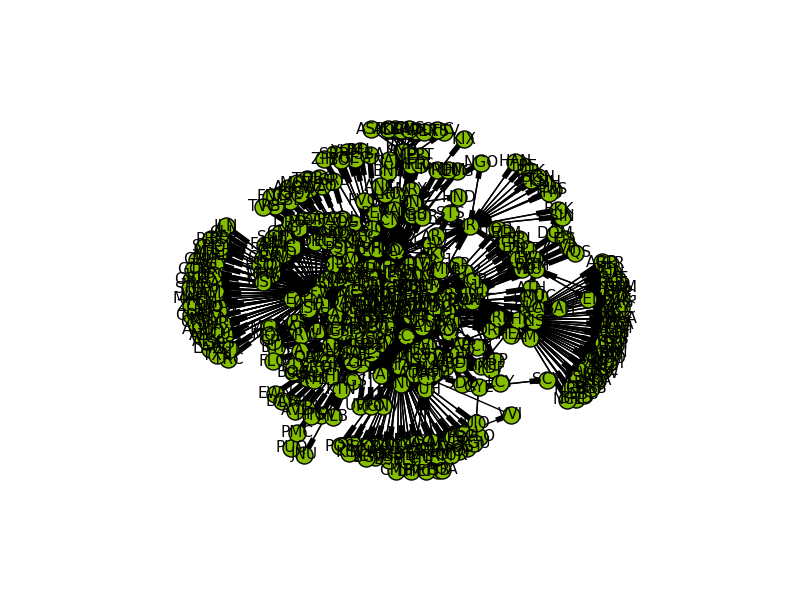

In [76]:
# Render the graph viz and save to file
f = plt.figure()
nx.draw_spring(gx, ax=f.add_subplot(111), 
               with_labels=True, 
               node_color=[0.522, 0.741, 0.], 
               node_size=150,
               font_size=11,
               ecolor=[0.37, 0.33, 0.33])
f.savefig("DATA620-Proj1-Centrality-Dittenhafer.png")
plt.close(f)

# Load the image we just saved
from IPython.display import Image
Image(filename='DATA620-Proj1-Centrality-Dittenhafer.png') 

### Gephi Screenshot

The following screenshot was taken after running the Fruchterman Reinhold layout algorithm, enabling labels, and color-coding green nodes/edges related to hubs, and red for not hubs. The airport DCA (Washington Reagan) has a degree level as high as the hubs, though it was not flagged as a hub. After a bit of investigating, there are several airports whose identifiers don't match between the data sets. DCA=WAS, JFK=NYC and ORD=CHI (Chicago O'Hare). But London Heathrow (LHR) genuinely has a high degree but is not flagged as a hub. For reference, the list of American Airlines hubs is shown below along with the top 10 nodes based on degree.

In [26]:
print(GetAaHubs(data))
top10

[u'DFW', u'LAX', u'CHI', u'MIA', u'NYC', u'CLT', u'PHL', u'PHX', u'WAS']


[('DFW', 364),
 ('CLT', 267),
 ('ORD', 248),
 ('MIA', 240),
 ('PHL', 235),
 ('LHR', 188),
 ('DCA', 148),
 ('PHX', 148),
 ('LAX', 138),
 ('JFK', 121)]

Note the LHR node in the top center with red edges, while PHL, MIA, DFW are green (representing the hubs).

![](Proj1-Gephi-IsHub.png)